# `Pretrained ImageClassification Model`
* ###  A machine learning model that has been trained on a large dataset for a specific task and can then be reused or fine-tuned for a different but related task.

# `Transfering Learning`

* ### Transfer learning is a machine learning technique where a model developed for one task is repurposed as a starting point for a second, related task

In [2]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sivakiran2
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification


100%|██████████| 155M/155M [00:00<00:00, 1.22GB/s]

In [3]:
# importing the necessary libraries

import torch
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import models
from tqdm.auto import tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image

device ="cuda" if torch.cuda.is_available() else "cpu"

In [4]:
device

'cuda'

In [5]:
train_df = pd.read_csv("/content/bean-leaf-lesions-classification/train.csv")
val_df = pd.read_csv("/content/bean-leaf-lesions-classification/val.csv")

train_df["image:FILE"]="/content/bean-leaf-lesions-classification/"+train_df["image:FILE"]
val_df["image:FILE"]="/content/bean-leaf-lesions-classification/"+val_df["image:FILE"]

In [6]:
train_df.head()

,image:FILE,category
0,/content/bean-leaf-lesions-classification/trai...,0
1,/content/bean-leaf-lesions-classification/trai...,0
2,/content/bean-leaf-lesions-classification/trai...,0
3,/content/bean-leaf-lesions-classification/trai...,0
4,/content/bean-leaf-lesions-classification/trai...,0


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1034 entries, 0 to 1033
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image:FILE  1034 non-null   object
 1   category    1034 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 16.3+ KB


In [8]:
train_df["category"].unique()

array([0, 1, 2])

In [9]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image:FILE  133 non-null    object
 1   category    133 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


In [10]:
print(train_df["category"].value_counts())

category
2    348
1    345
0    341
Name: count, dtype: int64


In [11]:
print(val_df["category"].value_counts())

category
2    45
0    44
1    44
Name: count, dtype: int64


In [12]:
# changing the image format of a dataset

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [13]:
# creating a custom dataset by transforming the data

class CustomeDataset(Dataset):
  def __init__(self,dataframe,transform=None):
    self.dataframe=dataframe
    self.transform=transform
    self.labels =torch.tensor(dataframe["category"]).to(device)

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self,indx):
    img_path =self.dataframe.iloc[indx,0]
    img = Image.open(img_path)
    if self.transform:
      img = (self.transform(img)/255.0).to(device)

    return img,self.labels[indx]



In [14]:
train_dataset =CustomeDataset(train_df,transform=transform)
val_dataset =CustomeDataset(val_df,transform=transform)

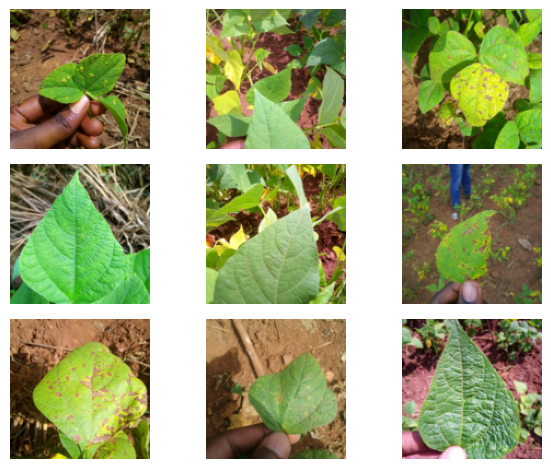

In [15]:
# visualizing the tensor data into image

n_rows=3
n_cols=3

f,axarr =plt.subplots(n_rows,n_cols)

for row in range(n_rows):
  for col in range(n_cols):
    image =train_dataset[np.random.randint(0,len(train_dataset))][0].cpu()
    axarr[row,col].imshow((image*255.0).squeeze().permute(1,2,0))
    axarr[row,col].axis("off")

plt.tight_layout()
plt.show()

In [16]:
image.shape

torch.Size([3, 128, 128])

In [17]:
# providing the hyperparameters for the given model
LR=1e-3
BATCH_SIZE=4
EPOCHS=15

In [18]:
image.shape

torch.Size([3, 128, 128])

In [19]:
# creating a train loader for dividing the data into batches

train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=True)

In [20]:
# loading the pretrained model
googlenet_model = models.googlenet(weights="DEFAULT").to(device)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


100%|██████████| 49.7M/49.7M [00:00<00:00, 56.8MB/s]


In [21]:
# iterating through the parameters
for param in googlenet_model.parameters():
  param.requires_grad=False


#   googlenet_model.parameters() → gives you all the learnable parameters (weights & biases) of the model.

# Looping through them lets you access each parameter tensor.

# param.requires_grad = False → tells PyTorch not to compute gradients for this parameter during backpropagation.

In [22]:
# changing the output features of the pretrained model

googlenet_model.fc
'''
in these model it is expecting 1000 classes are expected to predict but we only require 3 classes
to predict the model
'''

'\nin these model it is expecting 1000 classes are expected to predict but we only require 3 classes\nto predict the model\n'

In [23]:
# providing the number of classes for the give pretrained model

num_classes =len(train_df["category"].unique())
num_classes

3

In [24]:
# changing the num of classes in the linear layer with same input features

googlenet_model.fc =torch.nn.Linear(in_features=1024,out_features=num_classes).to(device)
googlenet_model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [25]:
# pretrained model
googlenet_model.fc

Linear(in_features=1024, out_features=3, bias=True)

In [26]:
# creating loss function and optimizerr

loss_fn=nn.CrossEntropyLoss() # calculating the difference between predicted and actual weights
optimizer=Adam(googlenet_model.parameters(),lr=LR) # used to optimize the weights

In [33]:
# building the training loop
total_loss_train_plot =[]
total_acc_train_plot =[]

for epoch in tqdm(range(EPOCHS)):
  train_loss=0
  train_acc=0

  for inputs, labels in train_loader:
    optimizer.zero_grad()

    ''' It resets (zeros out) all the gradients of the model parameters tracked by the optimizer.
By default, PyTorch accumulates gradients on each backward pass.
That means if you don’t call optimizer.zero_grad(), the gradients from the previous iteration will add up with the new ones — which is almost never what you want in training.
'''
    pred =googlenet_model(inputs)
    loss =loss_fn(pred,labels)
    train_loss+=loss.item()

    loss.backward() # back propogation to update the weigths

    # def train_step(model, optimizer, criterion, x, y):
    # optimizer.zero_grad()          # clear old gradients
    # out = model(x)                 # forward pass
    # loss = criterion(out, y)       # compute loss
    # loss.backward()                # backward pass (compute grads)
    # optimizer.step()               # update weights
    # return loss.item()


    acc=(torch.argmax(pred, axis=1)==labels).sum().item()
    train_acc+=acc
    optimizer.step() # update the weights

  total_loss_train_plot.append(round(train_loss/1000,4))
  total_acc_train_plot.append(round(train_acc/train_dataset.__len__()*100,4))
  print(f"Epoch{epoch+1}/{EPOCHS} |Train Loss:{round(train_loss/1000,4)} |Train Acc:{round(train_acc/train_dataset.__len__()*100,4)}%")


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch1/15 |Train Loss:0.2226 |Train Acc:63.6364%
Epoch2/15 |Train Loss:0.2129 |Train Acc:63.2495%
Epoch3/15 |Train Loss:0.2059 |Train Acc:63.6364%
Epoch4/15 |Train Loss:0.2146 |Train Acc:63.4429%
Epoch5/15 |Train Loss:0.2023 |Train Acc:65.2805%
Epoch6/15 |Train Loss:0.2063 |Train Acc:65.4739%
Epoch7/15 |Train Loss:0.2145 |Train Acc:62.3791%
Epoch8/15 |Train Loss:0.225 |Train Acc:62.8627%
Epoch9/15 |Train Loss:0.2054 |Train Acc:66.1509%
Epoch10/15 |Train Loss:0.2078 |Train Acc:64.7969%
Epoch11/15 |Train Loss:0.2062 |Train Acc:66.8279%
Epoch12/15 |Train Loss:0.2236 |Train Acc:61.8956%
Epoch13/15 |Train Loss:0.2107 |Train Acc:65.1838%
Epoch14/15 |Train Loss:0.2076 |Train Acc:65.3772%
Epoch15/15 |Train Loss:0.204 |Train Acc:65.8607%


In [39]:
with torch.inference_mode(): # disables gradient tracking and also optimizes certain backend operations for inference, making it faster and more memory efficient compared to
  val_loss=0
  val_acc=0

  for inputs, labels in val_loader:
    pred =googlenet_model(inputs)
    loss =loss_fn(pred,labels)
    val_loss+=loss.item()
    acc=(torch.argmax(pred, axis=1)==labels).sum().item()
    val_acc+=acc
  print(f"Val Loss:{round(val_loss/val_dataset.__len__(),4)} |Val Acc:{round(val_acc/val_dataset.__len__()*100,4)}%")


Val Loss:0.2292 |Val Acc:62.406%


In [43]:
# Transfer learning
googlenet_model = models.googlenet(weights="DEFAULT").to(device)

for param in googlenet_model.parameters(): # make model to learn on its own without pretrained data
  param.requires_grad=False

googlenet_model.fc=torch.nn.Linear(in_features=1024,out_features=num_classes).to(device)
googlenet_model.fc.requires_grad =True # tells to compute the gradients in back propogation


In [41]:
# building the training loop
total_loss_train_plot =[]
total_acc_train_plot =[]

for epoch in tqdm(range(EPOCHS)):
  train_loss=0
  train_acc=0

  for inputs, labels in train_loader:
    optimizer.zero_grad()
    pred =googlenet_model(inputs)
    loss =loss_fn(pred,labels)
    train_loss+=loss.item()

    loss.backward()

    acc=(torch.argmax(pred, axis=1)==labels).sum().item()
    train_acc+=acc
    optimizer.step()

  total_loss_train_plot.append(round(train_loss/1000,4))
  total_acc_train_plot.append(round(train_acc/train_dataset.__len__()*100,4))
  print(f"Epoch{epoch+1}/{EPOCHS} |Train Loss:{round(train_loss/1000,4)} |Train Acc:{round(train_acc/train_dataset.__len__()*100,4)}%")


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch1/15 |Train Loss:0.2947 |Train Acc:33.0754%
Epoch2/15 |Train Loss:0.2964 |Train Acc:30.0774%
Epoch3/15 |Train Loss:0.2944 |Train Acc:31.528%
Epoch4/15 |Train Loss:0.2951 |Train Acc:31.0445%
Epoch5/15 |Train Loss:0.2946 |Train Acc:32.205%
Epoch6/15 |Train Loss:0.2936 |Train Acc:32.0116%
Epoch7/15 |Train Loss:0.2948 |Train Acc:31.6248%
Epoch8/15 |Train Loss:0.2923 |Train Acc:32.4952%
Epoch9/15 |Train Loss:0.2949 |Train Acc:32.6886%
Epoch10/15 |Train Loss:0.2971 |Train Acc:29.6905%
Epoch11/15 |Train Loss:0.2955 |Train Acc:30.5609%
Epoch12/15 |Train Loss:0.2958 |Train Acc:32.3017%
Epoch13/15 |Train Loss:0.2947 |Train Acc:31.7215%
Epoch14/15 |Train Loss:0.2929 |Train Acc:34.4294%
Epoch15/15 |Train Loss:0.2937 |Train Acc:31.8182%


In [42]:

with torch.inference_mode():
  val_loss=0
  val_acc=0

  for inputs, labels in val_loader:
    pred =googlenet_model(inputs)
    loss =loss_fn(pred,labels)
    val_loss+=loss.item()
    acc=(torch.argmax(pred, axis=1)==labels).sum().item()
    val_acc+=acc
  print(f"Val Loss:{round(val_loss/val_dataset.__len__(),4)} |Val Acc:{round(val_acc/val_dataset.__len__()*100,4)}%")


Val Loss:0.3033 |Val Acc:27.0677%
